This notebook demonstrates some basic post-processing tasks that can be performed with the Python API, such as plotting a 2D mesh tally and plotting neutron source sites from an eigenvalue calculation. The problem we will use is a simple reflected pin-cell.

In [1]:
%matplotlib inline
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

import openmc

## Generate Input Files

First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H-1')
b10 = openmc.Nuclide('B-10')
o16 = openmc.Nuclide('O-16')
u235 = openmc.Nuclide('U-235')
u238 = openmc.Nuclide('U-238')
zr90 = openmc.Nuclide('Zr-90')

With the nuclides we defined, we will now create three materials for the fuel, water, and cladding of the fuel pin.

In [3]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

With our three materials, we can now create a materials file object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials collection
materials_file = openmc.Materials((fuel, water, zircaloy))
materials_file.default_xs = '71c'

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. Our problem will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces -- in this case two cylinders and six reflective planes.

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
# Use both reflective and vacuum boundaries to make life interesting
min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.63, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+0.63, boundary_type='reflective')

With the surfaces defined, we can now create cells that are defined by intersections of half-spaces created by the surfaces.

In [6]:
# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator_cell)

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [7]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = pin_cell_universe

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe, put the geometry into a geometry file, and export it to XML.

In [8]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

In [9]:
# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters. In this case, we will use 10 inactive batches and 90 active batches each with 5000 particles.

In [10]:
# OpenMC simulation parameters
batches = 100
inactive = 10
particles = 5000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

Let us also create a plot file that we can use to verify that our pin cell geometry was created successfully.

In [11]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.width = [1.26, 1.26]
plot.pixels = [250, 250]
plot.color = 'mat'

# Instantiate a Plots collection and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [12]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

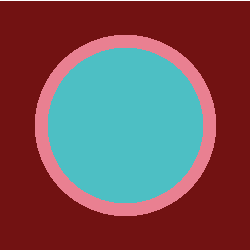

In [13]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have a nice pin cell with fuel, cladding, and water! Before we run our simulation, we need to tell the code what we want to tally. The following code shows how to create a 2D mesh tally.

In [14]:
# Instantiate an empty Tallies object
tallies_file = openmc.Tallies()

In [15]:
# Create mesh which will be used for tally
mesh = openmc.Mesh()
mesh.dimension = [100, 100]
mesh.lower_left = [-0.63, -0.63]
mesh.upper_right = [0.63, 0.63]

# Create mesh filter for tally
mesh_filter = openmc.Filter(type='mesh')
mesh_filter.mesh = mesh

# Create mesh tally to score flux and fission rate
tally = openmc.Tally(name='flux')
tally.filters = [mesh_filter]
tally.scores = ['flux', 'fission']
tallies_file.append(tally)

In [16]:
# Export to "tallies.xml"
tallies_file.export_to_xml()

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [17]:
# Run OpenMC!
openmc.run()


       .d88888b.                             888b     d888  .d8888b.
      d88P" "Y88b                            8888b   d8888 d88P  Y88b
      888     888                            88888b.d88888 888    888
      888     888 88888b.   .d88b.  88888b.  888Y88888P888 888       
      888     888 888 "88b d8P  Y8b 888 "88b 888 Y888P 888 888       
      888     888 888  888 88888888 888  888 888  Y8P  888 888    888
      Y88b. .d88P 888 d88P Y8b.     888  888 888   "   888 Y88b  d88P
       "Y88888P"  88888P"   "Y8888  888  888 888       888  "Y8888P"
__________________888______________________________________________________
                  888
                  888

      Copyright:      2011-2016 Massachusetts Institute of Technology
      License:        http://openmc.readthedocs.org/en/latest/license.html
      Version:        0.7.1
      Git SHA1:       df280b60eb1c6d7b7f842e05ede734a4883a0fc8
      Date/Time:      2016-05-05 14:41:55

 ========================>     INITIALIZA

0

## Tally Data Processing

Our simulation ran successfully and created a statepoint file with all the tally data in it. We begin our analysis here loading the statepoint file and 'reading' the results. By default, data from the statepoint file is only read into memory when it is requested. This helps keep the memory use to a minimum even when a statepoint file may be huge.

In [18]:
# Load the statepoint file
sp = openmc.StatePoint('statepoint.100.h5')

Next we need to get the tally, which can be done with the ``StatePoint.get_tally(...)`` method.

In [19]:
tally = sp.get_tally(scores=['flux'])
print(tally)

Tally
	ID             =	10000
	Name           =	flux
	Filters        =	
                		mesh	[10000]
	Nuclides       =	total 
	Scores         =	['flux', 'fission']
	Estimator      =	tracklength



The statepoint file actually stores the sum and sum-of-squares for each tally bin from which the mean and variance can be calculated as described [here](http://mit-crpg.github.io/openmc/methods/tallies.html#variance). The sum and sum-of-squares can be accessed using the ``sum`` and ``sum_sq`` properties:

In [20]:
tally.sum

array([[[ 0.40945685,  0.        ]],

       [[ 0.40939021,  0.        ]],

       [[ 0.410625  ,  0.        ]],

       ..., 
       [[ 0.41130501,  0.        ]],

       [[ 0.41228849,  0.        ]],

       [[ 0.41420317,  0.        ]]])

However, the mean and standard deviation of the mean are usually what you are more interested in. The Tally class also has properties ``mean`` and ``std_dev`` which automatically calculate these statistics on-the-fly.

In [21]:
print(tally.mean.shape)
(tally.mean, tally.std_dev)

(10000, 1, 2)


(array([[[ 0.00454952,  0.        ]],
 
        [[ 0.00454878,  0.        ]],
 
        [[ 0.0045625 ,  0.        ]],
 
        ..., 
        [[ 0.00457006,  0.        ]],
 
        [[ 0.00458098,  0.        ]],
 
        [[ 0.00460226,  0.        ]]]),
 array([[[  1.64748193e-05,   0.00000000e+00]],
 
        [[  1.70922989e-05,   0.00000000e+00]],
 
        [[  1.67622385e-05,   0.00000000e+00]],
 
        ..., 
        [[  1.69274948e-05,   0.00000000e+00]],
 
        [[  1.57842763e-05,   0.00000000e+00]],
 
        [[  2.06590062e-05,   0.00000000e+00]]]))

The tally data has three dimensions: one for filter combinations, one for nuclides, and one for scores. We see that there are 10000 filter combinations (corresponding to the 100 x 100 mesh bins), a single nuclide (since none was specified), and two scores. If we only want to look at a single score, we can use the ``get_slice(...)`` method as follows.

In [22]:
flux = tally.get_slice(scores=['flux'])
fission = tally.get_slice(scores=['fission'])
print(flux)

Tally
	ID             =	10001
	Name           =	flux
	Filters        =	
                		mesh	[10000]
	Nuclides       =	total 
	Scores         =	['flux']
	Estimator      =	tracklength



To get the bins into a form that we can plot, we can simply change the shape of the array since it is a numpy array.

In [23]:
flux.std_dev.shape = (100, 100)
flux.mean.shape = (100, 100)
fission.std_dev.shape = (100, 100)
fission.mean.shape = (100, 100)

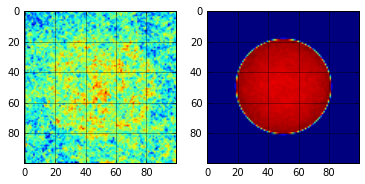

In [24]:
fig = plt.subplot(121)
fig.imshow(flux.mean)
fig2 = plt.subplot(122)
fig2.imshow(fission.mean)

Now let's say we want to look at the distribution of relative errors of our tally bins for flux. First we create a new variable called ``relative_error`` and set it to the ratio of the standard deviation and the mean, being careful not to divide by zero in case some bins were never scored to.

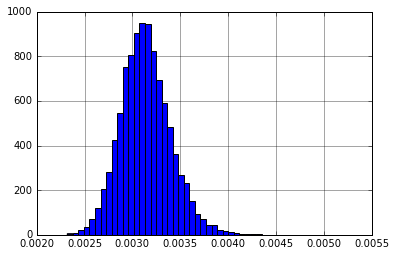

In [25]:
# Determine relative error
relative_error = np.zeros_like(flux.std_dev)
nonzero = flux.mean > 0
relative_error[nonzero] = flux.std_dev[nonzero] / flux.mean[nonzero]

# distribution of relative errors
ret = plt.hist(relative_error[nonzero], bins=50)

## Source Sites

Source sites can be accessed from the ``source`` property. As shown below, the source sites are represented as a numpy array with a structured datatype.

In [26]:
sp.source

array([ (1.0, [-0.1382758052991497, -0.3512177196880901, -0.33148352853135243], [0.4185689312254184, 0.515870835450486, -0.7474472094699589], 0.12980877137486158, 0),
       (1.0, [-0.1382758052991497, -0.3512177196880901, -0.33148352853135243], [-0.7887279871402189, -0.41474066458733805, -0.4537602268152112], 0.9055673129689725, 0),
       (1.0, [-0.037141545763691594, 0.3164763430804079, -0.13705878399440294], [0.3855911650385466, 0.7867859791128493, -0.48196190359368796], 0.996776361155944, 0),
       ...,
       (1.0, [0.10735654583359178, -0.007276312264885898, -0.05173760352485271], [0.5349120379020222, -0.015907381482490993, 0.8447579931091957], 0.8409377635712494, 0),
       (1.0, [-0.048566216245400286, 0.29160532148505824, 0.31942717397594755], [0.6200960701401188, -0.409911862042636, 0.6689193741801173], 3.8787384499997857, 0),
       (1.0, [0.07888442268099938, -0.14443885526015943, 0.3095767587545024], [0.373899151360205, 0.18819594431853104, 0.9081749342247754], 4.7761475

If we want, say, only the energies from the source sites, we can simply index the source array with the name of the field:

In [27]:
sp.source['E']

array([ 0.12980877,  0.90556731,  0.99677636, ...,  0.84093776,
        3.87873845,  4.77614759])

Now, we can look at things like the energy distribution of source sites. Note that we don't directly use the ``matplotlib.pyplot.hist`` method since our binning is logarithmic.

1.0


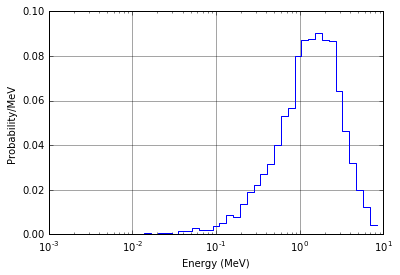

In [28]:
# Create log-spaced energy bins from 1 keV to 100 MeV
energy_bins = np.logspace(-3,1)

# Calculate pdf for source energies
probability, bin_edges = np.histogram(sp.source['E'], energy_bins, density=True)

# Make sure integrating the PDF gives us unity
print(sum(probability*np.diff(energy_bins)))

# Plot source energy PDF
plt.semilogx(energy_bins[:-1], probability*np.diff(energy_bins), linestyle='steps')
plt.xlabel('Energy (MeV)')
plt.ylabel('Probability/MeV')

Let's also look at the spatial distribution of the sites. To make the plot a little more interesting, we can also include the direction of the particle emitted from the source and color each source by the logarithm of its energy.

(-0.5, 0.5)

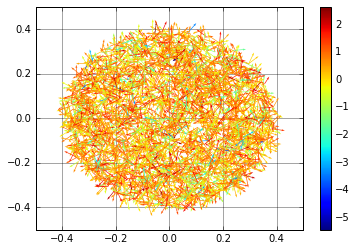

In [29]:
plt.quiver(sp.source['xyz'][:,0], sp.source['xyz'][:,1],
           sp.source['uvw'][:,0], sp.source['uvw'][:,1],
           np.log(sp.source['E']), cmap='jet', scale=20.0)
plt.colorbar()
plt.xlim((-0.5,0.5))
plt.ylim((-0.5,0.5))